# 머신러닝을 통한 타이타닉 생존 예측하기

타이타닉호에서 승객이 살아남았는지, 죽었는지 예측하는 것이다. 각각의 feature(칼럼)을 통해서 우리가 필요한 기술들을 통해 변환하고 다듬는 작업으로 예측할 모델을 생성하고 평가를 해보는 것이다.

## Data

* survival: 0 = No, 1 = Yes
* pclass	Ticket class: 1 = 1st(Upper), 2 = 2nd(Middle), 3 = 3rd(Lower)
* sex	
* Age: in years	
* sibsp(family relations):	# of siblings / spouses aboard the Titanic
  Sibling = brother, sister, stepbrother, stepsister
* parch:	# of parents / children aboard the Titanic
  Parent = mother, father
  Child = daughter, son, stepdaughter, stepson
  Some children travelled only with a nanny, therefore parch=0 for them.

* ticket:	Ticket number	
* fare:	Passenger fare	
* cabin:	Cabin number	
* embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton




In [0]:
# 데이터 불러오기, 데스크탑 타이타닉 파일 업로드
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 데이터 앞부분만 읽어보기
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
train.shape

(891, 12)

In [0]:
test.shape

(418, 11)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [0]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# Bar Chart for Categorical Features(칼럼)
* Pclass
* Sex
* SibSp ( # of siblings and spouse)
* Parch ( # of parents and children)
* Embarked
* Cabin

In [0]:
# 데이터 시각화하기
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() #setting seaborn default for plots

In [0]:
def bar_chart(feature):
  survived = train[train['Survived']==1][feature].value_counts()
  dead = train[train['Survived']==0][feature].value_counts()
  df = pd.DataFrame([survived, dead])
  df.index = ['Survived', 'Dead']
  df.plot(kind = 'bar', stacked = True, figsize = (10,5))

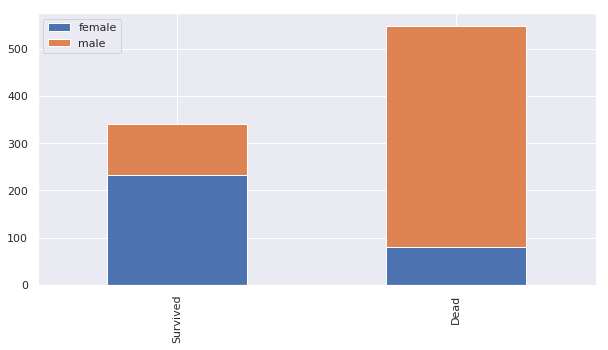

In [0]:
bar_chart('Sex')

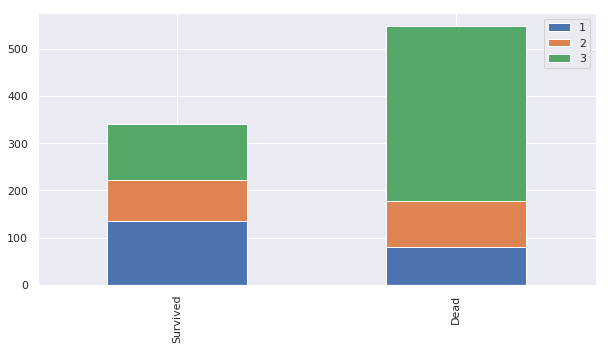

In [0]:
bar_chart('Pclass')

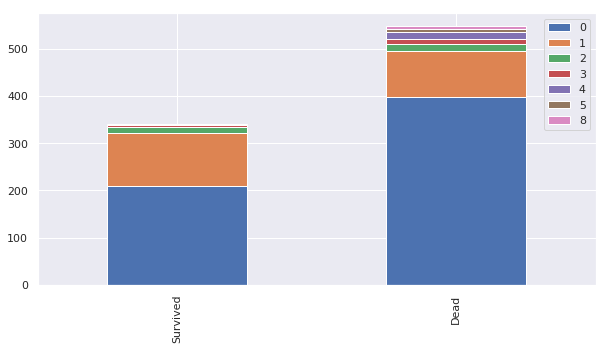

In [0]:
bar_chart('SibSp')

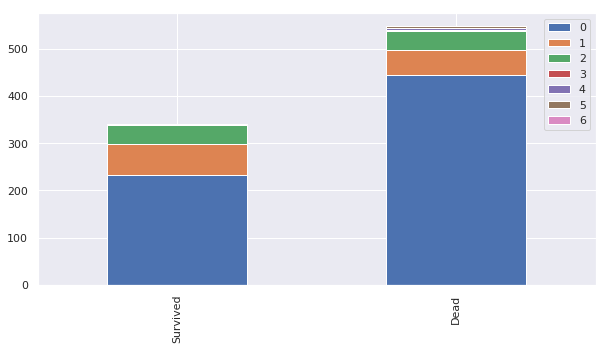

In [0]:
bar_chart('Parch')

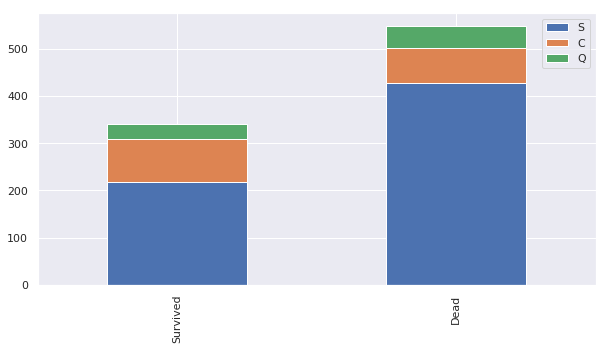

In [0]:
bar_chart('Embarked')

# Feature engineering

feature 엔지니어링은 머신러닝 알고리즘을 통해 feature 벡터를 생성하는 작업을 하는 것이다.
다시말해서, 머신러닝 알고리즘을 작동하기 위해 데이터에 대한 도메인 지식을 활용하여 특징(Feature)를 만들어내는 과정이다. 또 다른 정의를 살펴보면, 머신러닝 모델을 위한 데이터 테이블의 컬럼(특징)을 생성하거나 선택하는 작업을 의미한다. Feature Engineering은 모델 성능에 미치는 영향이 크기 때문에 머신러닝 응용에 있어서 굉장히 중요한 단계이다. 우리는 갖추어진 과정과 통계학적인 분석을 통해 작업을 해보자.


## why is the important feature engineering?

입력 데이터의 함수이며 선형 또는 비선형의 형태를 가질 수 있는데, 우리는 훈련 데이터를 사용해서 이 함수를 학습하지만, 매번 학습이 잘되어 결과가 나타나지 않는다. 내가 가지고 있는 데이터가 방대하다해도 그 데이터를 모두 결과를 도출하는데 쓰면 정확히 나타날 듯하지만 오히려 결과를 잘못되게 도출하는 경우가 많다.

즉, 머신 러닝의 성능은 어떤 데이터를 입력하는지가 굉장히 의존적이라는 것을 알 수 있다. 가장 이상적인 입력 데이터는 부족하지도 과하지도 않은 정확한 정보만 포함될 때이다. 그렇기에 가장 적절 한 방법은 먼저 충분한 데이터를 먼저 모으고 어떤 feature가 유용한지 아닌지 확인하는 과정을 거칩니다. feature가 유용한지 아닌지 확인하는 과정을 특징 선택(feature selection) 또는 특징 추출(feature extraction) 이라고 한다. 해당 과정은 기존 입력을 토대로 새로운 입력 데이터를 만들기 때문에 보통 learning 과정 전에 실행된다.

## Dimention Reduction

차원 감소는 feature extraction 다시 말해 특징 추출이라는 말로도 불린다. 만약 하나의 종속변수를 설명하는 독립변수 3개를 가지고 있을 때 우리는 3개의 feature모두가 필요한 것은 아니다. 왜냐면 몇몇의 feature는 다른 특징들의 조합으로 표현가능할 수도있고 어떤 feature는 특정 feature의 완벽히 상반될 수 있기 때문이다. 이것을 다른 말로 관찰 대상들을 잘 설명할 수 있는 잠재 공간(latent space)은 실제 관찰 공간(observation space)보다 작을 수 있다고 하고 이렇게 관찰 공간 위의 샘플들에 기반으로 잠재 공간을 파악하는 것을 차원 축소(dimensionality reduction technique) 라고 한다. 이렇게 데이터의 차원을 줄이는 데에는 특징 선택(feature selection)과 특징 추출 (feature extraction) 두 가지 방법이 있다.

### feature selection

특징 선택의 목적은 모든 특징의 부분 집합을 선택하거나, 불필요한 특징을 제거하여 간결한 특징 집합을 만드는 것이다. 이런 특징선택은 분석자가 사전의 배경 지식 을 이용해서 진행 할 수도 있지만, 자동 특징 선택 (automatic feature selection methods)을 사용할 수도 있다. 해당 방법들은 특징 중 몇 개를 없애보고 개선된다면 성능을 확인해보는 방법이며 이것은 대부분의 특징 선택 알고리즘의 기본 동작방식이다.

### feature extraction

고차원의 원본 feature 공간을 저차원의 새로운 feature 공간으로 투영시킨다. 새롭게 구성된 feature 공간은 보통은 원본 feature 공간의 선형 또는 비선형 결합이다.

가장 대표적인 알고리즘에 PCA(Principle Component Analysis)가 있다. PCA를 간단히 설명하면 각 변수(Feature)를 하나의 축으로 투영시켰을 때 분산이 가장 큰 축을 첫번째 주성분으로 선택하고 그 다음 큰 축을 두번째 주성분으로 선택하고 데이터를 선형 변환하여 다차원을 축소하는 방법이다.


In [0]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# 맵핑(Mapping)

Many algorithms need to map a key to a data value. This kind of mapping is supported by the Python dictionary, dict. We’ll look at dictionaries from a number of viewpoints: semantics, literal values, operations, comparison operators, statements, built-in functions and methods.

We are then in a position to look at two applications of the dictionary. We’ll look at how Python uses dictionaries along with sequences to handle arbitrary connections of parameters to functions in Advanced Parameter Handling For Functions. This is a very sophisticated set of tools that let us define functions that are very flexible and easy to use.

# feature 정규화

정규화의 목적은 데이터 범위 숫자열 값을 변경하여 값 범위의 차이를 수정하지 않고 공통 척도로 사용하는 것이다.판다스에서는 MinMaxScaler 클래스를 사용하여 각 열의 특정값 범위로 확장할 수 있습니다.

In [0]:
ㄷtrain_test_data = [train, test] # 결합하기 train and test dataset

for dataset in train_test_data:
  dataset['Title'] = dataset['Name'].str.extract('([A-za-z]+)\.', expand = False)

In [0]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Sir           1
Capt          1
Ms            1
Jonkheer      1
Countess      1
Mme           1
Don           1
Lady          1
Name: Title, dtype: int64

In [0]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64

In [0]:
# 데이터 맵핑 작업, 머신러닝에서 문자열 인식하기 어렵기 때문에 숫자열로 바꾸어 준다.
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2,
                 "Master":3, "Dr": 3, "Rev": 3,"Col": 3, "Major": 3, "Mlle": 3, "Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkneer": 3, "Don": 3, "Dona": 3, "Mme": 3, "Capt": 3, "Sir": 3}
for dataset in train_test_data:
  dataset['Title'] = dataset['Title'].map(title_mapping)

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


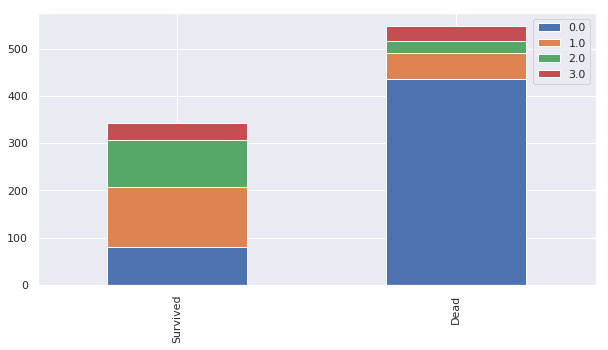

In [0]:
bar_chart('Title')

In [0]:
# 불필요한 데이터를 지운다, 맵핑작업을 통해 Title feature을 만들어주었기 때문에 Name을 지운다.
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [0]:
# 성별 맵핑 작업
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
  dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0.0


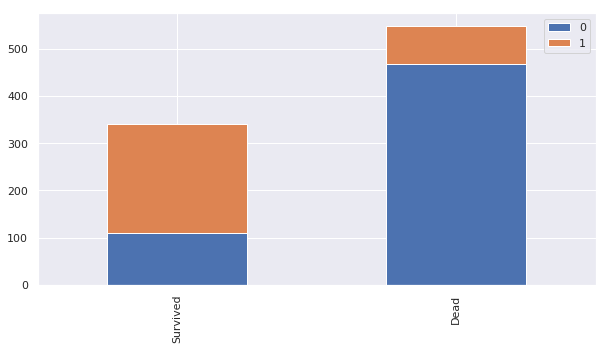

In [0]:
bar_chart('Sex')

In [0]:
train.head(100)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.00,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,38.00,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,35.00,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,35.00,0,0,373450,8.0500,NaN,S,0.0
5,6,0,3,0,NaN,0,0,330877,8.4583,NaN,Q,0.0
6,7,0,1,0,54.00,0,0,17463,51.8625,E46,S,0.0
7,8,0,3,0,2.00,3,1,349909,21.0750,NaN,S,3.0
8,9,1,3,1,27.00,0,2,347742,11.1333,NaN,S,2.0
9,10,1,2,1,14.00,1,0,237736,30.0708,NaN,C,2.0


In [0]:
# fill missing age with median age for each title(Mr,Mrs, Miss, Others) 
# Age에 있는 NaN값을 채워주기 위해서 Mr, Mrs, Miss 각각의 나이별 평균나이를 계산하여 집어 넣어준다. 
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace = True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace = True)

In [0]:
train.head(30)
train.groupby("Title")["Age"].transform("median")

0      30.0
1      35.0
2      21.0
3      35.0
4      30.0
5      30.0
6      30.0
7       9.0
8      35.0
9      35.0
10     21.0
11     21.0
12     30.0
13     30.0
14     21.0
15     35.0
16      9.0
17     30.0
18     35.0
19     35.0
20     30.0
21     30.0
22     21.0
23     30.0
24     21.0
25     35.0
26     30.0
27     30.0
28     21.0
29     30.0
       ... 
861    30.0
862    35.0
863    21.0
864    30.0
865    35.0
866    21.0
867    30.0
868    30.0
869     9.0
870    30.0
871    35.0
872    30.0
873    30.0
874    35.0
875    21.0
876    30.0
877    30.0
878    30.0
879    35.0
880    35.0
881    30.0
882    21.0
883    30.0
884    30.0
885    35.0
886     9.0
887    21.0
888    21.0
889    30.0
890    30.0
Name: Age, Length: 891, dtype: float64

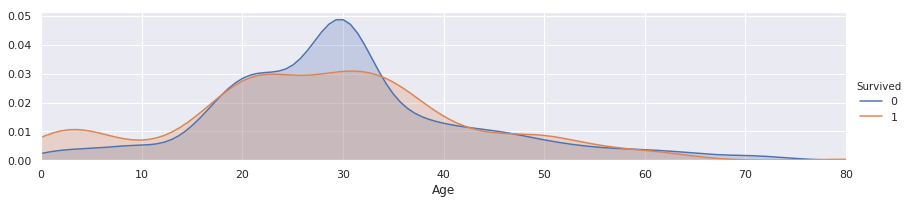

In [0]:
import seaborn as sns
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

(0, 20)

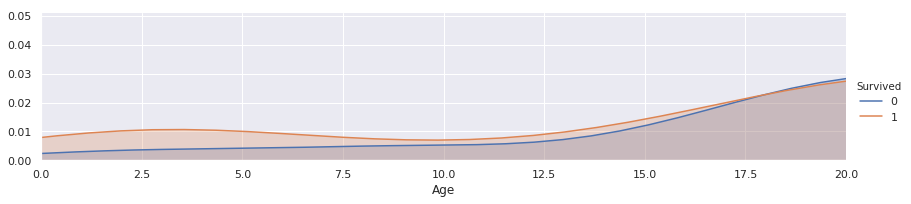

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(0, 20)


(20, 30)

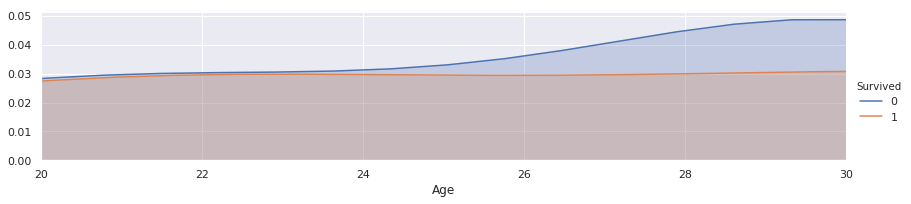

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(20, 30)


(30, 40)

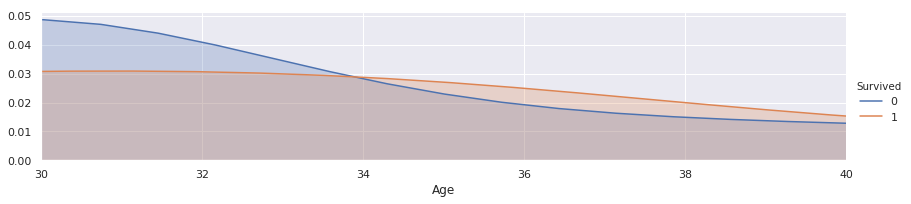

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(30, 40)

(40, 50)

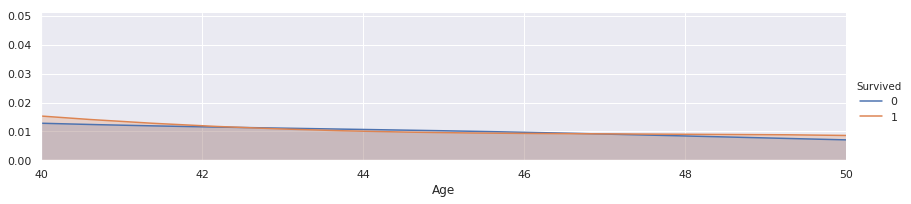

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(40, 50)

(50, 60)

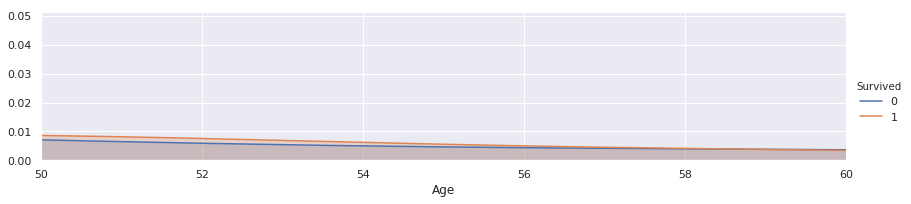

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.xlim(50, 60)

# 나이별로 생존, 죽음을 시각화해서 확인해보기

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          890 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.6+ KB


In [0]:
# Binning 기술 사용하여 나이별로 범주화하기, 정보를 명확하기 하기 위해서 = 나이의 범위가 너무 크기때문에 작은값으로 축소해준다고 생각하면 쉽다.
for dataset in train_test_data:
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
  dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
  dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
  dataset.loc[ dataset['Age'] > 62, 'Age'] = 4
  
 # featrue vector map을 보면 chid:0, young:1, adult:2, mid-age:3, senior:4

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0.0


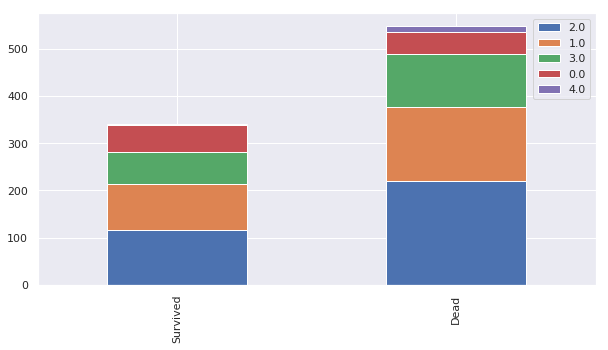

In [0]:
bar_chart('Age')

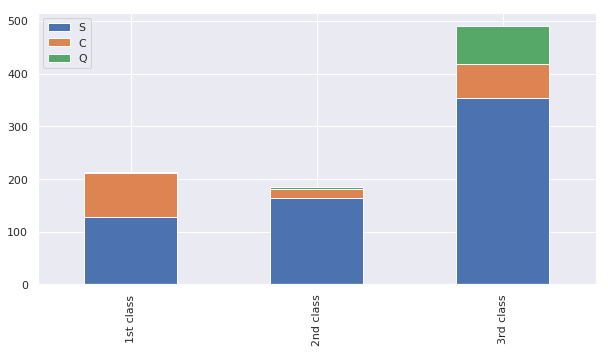

In [0]:
# embarked의 문자열을 숫자로 바꿔준다. 
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked = True, figsize = (10, 5))

# 1st class, 2st classs, 3st class의 50%이상이 S이다.

In [0]:
# embarked 결측치 넣는 방법, 즉 embarked 정보가 없으면 S를 넣는다.
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0.0


In [0]:
# 텍스트를 숫자로 바꾸기, S:0, C:1, Q:2로
embarked_mapping = {"S":0, "C":1, "Q": 2}
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [0]:
# 티켓 가격은 티켓클래스와 상관관계가 있으므로 빠진 값을 넣어주기
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace = True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace = True)

In [0]:
train.head(50)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0.0
5,6,0,3,0,2.0,0,0,330877,8.4583,NaN,2,0.0
6,7,0,1,0,3.0,0,0,17463,51.8625,E46,0,0.0
7,8,0,3,0,0.0,3,1,349909,21.0750,NaN,0,3.0
8,9,1,3,1,2.0,0,2,347742,11.1333,NaN,0,2.0
9,10,1,2,1,0.0,1,0,237736,30.0708,NaN,1,2.0


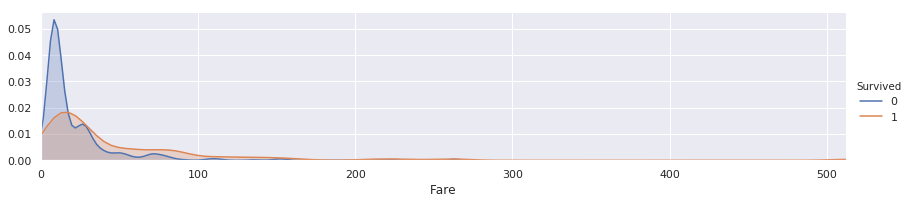

In [0]:
# farer과 생존, 죽음의 시각화하기
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Fare', shade = True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.show()

(0, 20)

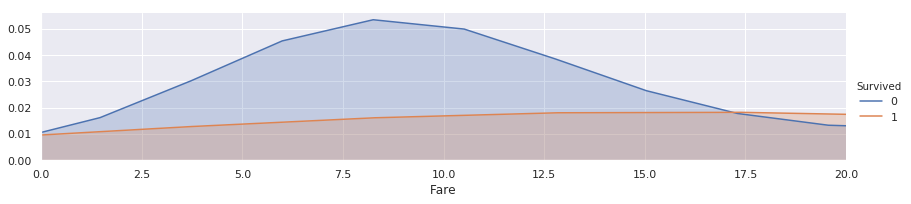

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Fare', shade = True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.xlim(0, 20)

(0, 30)

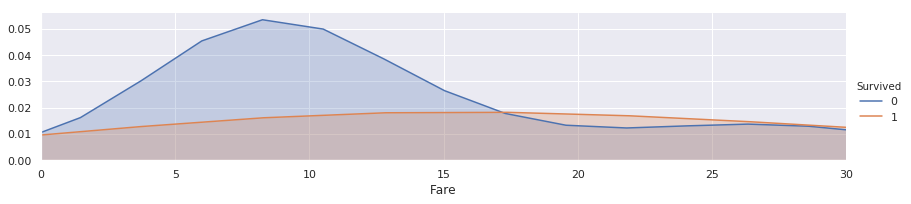

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Fare', shade = True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.xlim(0, 30)

(0, 512.3292)

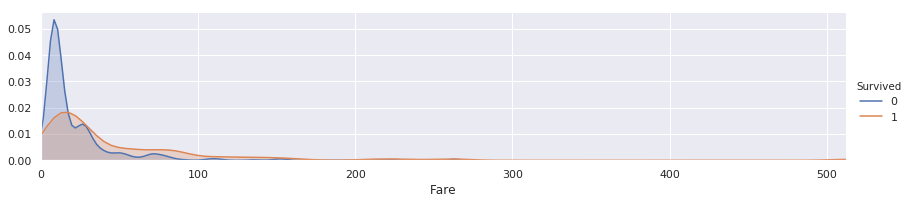

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'Fare', shade = True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.xlim(0)

In [0]:
# Binning 기술을 이용하여 17달러 이하는 0, 17~30은 1, 30~100은 2, 100이상은 3으로 범주화시킨다.
for dataset in train_test_data:
  dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
  dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
  dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
  dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,NaN,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C85,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,NaN,0,1.0
3,4,1,1,1,2.0,1,0,113803,2.0,C123,0,2.0
4,5,0,3,0,2.0,0,0,373450,0.0,NaN,0,0.0


In [0]:
# cabin 탑승 시 객실등급
train.Cabin.value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
C22 C26            3
D                  3
F33                3
E101               3
F2                 3
B28                2
B22                2
E121               2
B77                2
B20                2
B57 B59 B63 B66    2
E44                2
B18                2
D26                2
B35                2
E25                2
B58 B60            2
D33                2
C124               2
C78                2
C92                2
D17                2
C52                2
E33                2
F G73              2
E24                2
E8                 2
                  ..
C103               1
E34                1
C7                 1
D45                1
B4                 1
E10                1
C62 C64            1
B30                1
B102               1
D28                1
C110               1
C91                1
E58                1
D9                 1
C30                1
A36                1
B82 B84      

In [0]:
for dataset in train_test_data:
  dataset['Cabin'] = dataset['Cabin'].str[:1]

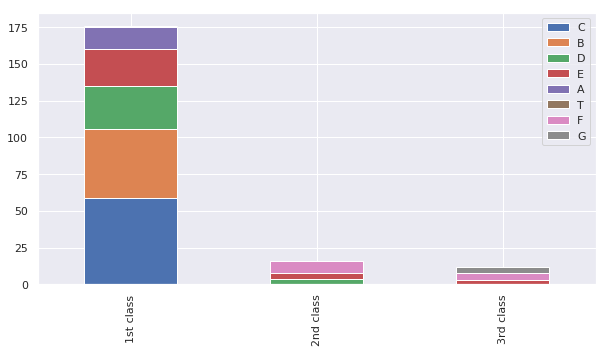

In [0]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked = True, figsize = (10, 5))

In [0]:
# feature 스케일링, 소수점의 숫자로 표현하지 않으면 안된다.
cabin_mapping = {"A":0, "B":0.4, "C": 0.8, "D":1.2, "E":1.6, "F": 2, "G":2.4, "T":2.8}
for dataset in train_test_data:
  dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [0]:
# 결측값 넣어주기
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace = True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace = True)

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1.0
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2.0
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0.0


In [0]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2
2,894,2,0,3.0,0,0,240276,0.0,2.0,2,0
3,895,3,0,2.0,0,0,315154,0.0,2.0,0,0
4,896,3,1,1.0,1,1,3101298,0.0,2.0,0,2


In [0]:
# Family Size라는 feature를 만들고 SibSp과 Parch값을 더하는 작업
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

(0, 11.0)

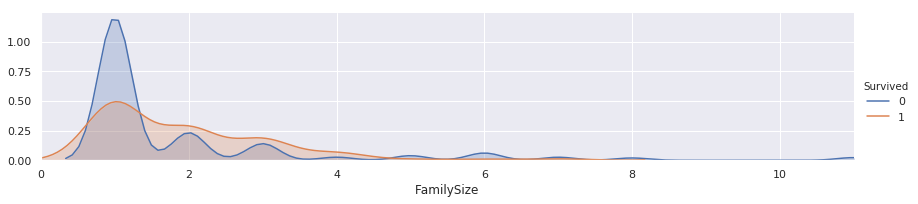

In [0]:
facet=sns.FacetGrid(train, hue = "Survived", aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade = True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()

plt.xlim(0)

In [0]:
# famillysize 맵핑작업
familly_mapping = {1:0, 2:0.4, 3:0.8, 4:1.2, 5:1.6, 6:2, 7:2.4, 8:2.8, 9:3.2, 10:3.6, 11:4}
for dataset in train_test_data:
  dataset['FamilySize'] = dataset['FamilySize'].map(familly_mapping)

In [0]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0.0,0.4
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2.0,0.4
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1.0,0.0
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2.0,0.4
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0.0,0.0


In [0]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0,0.0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2,0.4
2,894,2,0,3.0,0,0,240276,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0,0,315154,0.0,2.0,0,0,0.0
4,896,3,1,1.0,1,1,3101298,0.0,2.0,0,2,0.8


In [0]:
# 필요없는 정보를 dataset에서 없애기
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis =1)
test = test.drop(features_drop, axis =1)
train = train.drop(['PassengerId'], axis =1)

In [0]:
# survied라는 데이터 삭제하고 새로운 변수에 집어놓기
train_data = train.drop('Survived', axis =1)
target = train['Survived']

train_data.shape, target.shape

((891, 8), (891,))

In [0]:
train_data.head(10)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0.0,0.4
1,1,1,3.0,2.0,0.8,1,2.0,0.4
2,3,1,1.0,0.0,2.0,0,1.0,0.0
3,1,1,2.0,2.0,0.8,0,2.0,0.4
4,3,0,2.0,0.0,2.0,0,0.0,0.0
5,3,0,2.0,0.0,2.0,2,0.0,0.0
6,1,0,3.0,2.0,1.6,0,0.0,0.0
7,3,0,0.0,1.0,2.0,0,3.0,1.6
8,3,1,2.0,0.0,2.0,0,2.0,0.8
9,2,1,0.0,2.0,1.8,1,2.0,0.4


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         890 non-null float64
FamilySize    891 non-null float64
dtypes: float64(5), int64(3)
memory usage: 55.8 KB


In [0]:
# 데이터 타입을 보면 실수형(float64)가 너무 많다, 해당 feature를 정수형(int64)으로 변환해주는 함수를 활용하여 변환한다.
train_data['Age'] = np.int64(train_data)
train_data['Fare'] = np.int64(train_data)
train_data['Cabin'] = np.int64(train_data)
train_data['Title'] = np.int64(train_data)
train_data['FamilySize'] = np.int64(train_data)

In [0]:
# 다시 info()를 써서 output해보면 Age, Fare, Cabin, Title, FamilySize가 int64로 바꼈다는 것을 볼 수 있다.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null int64
Fare          891 non-null int64
Cabin         891 non-null int64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null int64
dtypes: int64(8)
memory usage: 55.8 KB


# 머신러닝 기법

어떠한 문제에 대해 기계(컴퓨터)가 데이터를 학습(훈련)하여 새로운 데이터가 들어왔을 때 원하는 결과를 예측할 수 있는 알고리즘을 말한다.

그러므로 개발자가 직접 어떠한 문제에 대한 원인 및 결과를 예측하여 입력에 대한 결과가 동일하게 나오는 알고리즘을 작성하지 않고 모델로부터 결과를 예측하는 알고리즘과 데이터를 기반하여 수치적 모델을 변경 할 수 있는 알고리즘을 작성하여 입력된 데이터에 따라 기계가 스스로 최적화된 수치 모델을 찾아 나가도록 한다.
이것은 학습방법에 따라 크게 두 가지로 나눌 수 있는데, 지도학습은  데이터에 예측하고자 하는 목적 속성이 있어 예측 모델을 구축한다. 하지만 비지도학습은 목적 속성 없이 기술 모델을 구축한다.

## 지도학습

지도학습은 사전에 학습할 데이터에 대하여 정답 정보가 작성된 데이터를 가지고 미리 학습한 다음 이후 시스템에서 활용 시 새로운 정보(=미래정보)가 입력되면 학습된 데이터를 바탕으로 그 결과를 도출한다.
사전에 학습할 정보들은 학습에 사용될 파라미터 값들과 해당 값들에 대한 실제 결과가 적혀져 있다. 기계학습에선 이렇게 결과값들이 적혀져 있는 데이터들을 라벨링 된 데이터라고 부른다. 지도학습은 이 데이터들을 토대로 여러 번의 테스트를 통해 파라미터 값 중 결과에 유의미한 영향을 미치는 파라미터를 추출하고 그 값들을 토대로 기계학습을 수행한다. 위 과정을 거친 후 만족할만한 기계학습 결과가 나온다면, 이 지도학습 결과를 시스템에 반영한다.
기계학습을 수행하다 보면 최적화(Optimization) 과 과잉학습(Over fitting)문제에 자주 부딪치게 되는데, 지도학습을 토대로 이러한 문제들에 대한 충분한 테스트를 거친 후 알맞은 학습 결과를 서비스에 반영할 수 있다. 하지만 지도학습의 경우 학습이 완료된 후 학습된 결과를 서비스에 반영하므로, 새로운 미래 데이터가 들어오더라도 기존 학습 결과를 강화하지 못하는 단점이 있다. 이를 보강하기 위해 최근 강화학습에 대한 관심이 증가하고 있다.

## 비지도학습

비지도 학습은 사전에 정답 정보가 기록된 학습데이터가 없이 데이터를 학습한다. 데이터에 대한 정답셋, 즉 라벨 정보가 없으므로 주로 입력되는 파라미터의 특성을 통해 데이터를 분류(Classification)하는 알고리즘이 대부분이며, 주로 초기 데이터 결과들의 새로운 특성 혹은 유의미한 상관관계를 찾는 분석 연구에 많이 사용된다.

## 사이킷런(scikit-learn)

사이킷런 라이브러리의 구성은 크게 지도학습(Supervised Learning), 비지도학습(Unsupervised Learning), 모델 선택 및 평가, 데이터 변환으로 나눌 수 있다. 지도학습에는 서포트 벡터 머신, 나이브 베이즈(Naive Bayes), 의사결정 나무(Decision Tree) 등이 있고, 비지도학습에는 군집화, 이상치 검출 등이 있다. 또한 모델 선택 및 평가에는 교차 검증(cross-validation), 파이프라인(pipeline) 등이 있고, 데이터 변환에는 속성 추출(Feature Extraction), 전처리(Preprocessing) 등이 있다.

참고 자료: https://scikit-learn.org/stable/modules/classes.html

## k-최근접 이웃법

k-최근접 이웃 알고리즘 (k-NN) 은 가장 쉬운 기계학습 알고리즘 중 하나입니다. 분류 문제에 사용하는 알고리즘으로서 새로운 데이터가 들어왔을 때 기존 데이터의 그룹 붕 어떤그룹에 속하는지를 분류하는 문제에 사용합니다.

## 의사결정나무

의사결정트리는 전형적인 분류 모델이며 매우 직관적인 방법 중 하나입니다. 다른 모델들과는 다르게 결과물이 시각적으로 읽히기 쉬운형태로 나타나는 것이 장점이기 때문에, 대출을 원하는 사람의 신용평가를 하고 싶을 때, 독버섯과 버섯을 분류하고 싶을 때 등 실질적으로 분류하는 경우에 자주 사용됩니다.

## 랜덤포레스트

랜덤 포레스트는 기본적으로 조금씩 다른 여러 결정 트리의 묶음입니다. 랜덤 포레스트의 아이디어는 각 트리는 비교적 예측을 잘 할 수 있지만 데이터의 일부에 과대적합하는 경향을 가진다는 데 기초합니다. 예컨대 잘 작동하되 서로 다른 방향으로 과대적합된 트리를 많이 만들면 그 결과를 평균냄으로써 과대적합된 양을 줄일 수 있습니다. 이렇게 하면 트리 모델의 예측 성능이 유지되면서 과대적합이 줄어드는 것이 수학적으로 증명되었습니다.



## 가우시안 나이베이즈 모형

연속적인 값을 지닌 데이터를 처리 할때, 전형적으로 각 클래스의 연속적인 값들이 가우스 분포를 따른다고 가정한다. 가우시안 나이브베이즈 모형 GaussianNB은 가능도 추정과 관련하여 다음과 같은 속성을 가진다.

* theta_: 정규분포의 기댓값  𝜇
* sigma_: 정규분포의 분산  𝜎2


## 서포트 벡터머신

자료 분석을 위한 지도 학습 모델이며, 주로 분류와 회귀 분석을 위해 사용한다. 두 카테고리 중 어느 하나에 속한 데이터의 집합이 주어졌을 때, SVM 알고리즘은 주어진 데이터 집합을 바탕으로 하여 새로운 데이터가 어느 카테고리에 속할지 판단하는 비확률적 이진 선형 분류 모델을 만든다. 만들어진 분류 모델은 데이터가 사상된 공간에서 경계로 표현되는데 SVM 알고리즘은 그 중 가장 큰 폭을 가진 경계를 찾는 알고리즘이다. SVM은 선형 분류와 더불어 비선형 분류에서도 사용될 수 있다. 

In [0]:
# how to classifier?, kNN 알고리즘- 가까이 있는 확률를 통해 예측하기, 변수를 변화시켜서 어떤식으로 예측을 하는지 확인하기
# decision tree 자식이 있었는지, 
# 랜덤포레스트
# Naive Bayes 베이지안 확률공식에 따른
# SVM support vector machine: 
# how do you vaildate your mode?, 보완 k-fold cross validation



In [0]:
# modeling하기, 분류 시 사용되는 여러가지 기법
# importing classifier modeling, sklearn에 있는 classifier import하기
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# 평균 등을 계산
import numpy as np

In [0]:
# Cross Validation(K-fold) import하기
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# train data를 10개로 등분할 예정, 10개 등분하기 전에 shuffle로 전체 데이터를 섞는다, 그 후에는  10개 쪼개는 과정에서 셔플을 안한다.
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [0]:
# KNN classifier, k=13개 neighbor를 사용한다.
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv = k_fold, n_jobs = 1, scoring=scoring)
print(score)

[0.82222222 0.82022472 0.78651685 0.79775281 0.83146067 0.84269663
 0.7752809  0.82022472 0.7752809  0.78651685]


In [0]:
# KNN score
round(np.mean(score)*100, 2)

80.58

In [0]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv = k_fold, n_jobs =1, scoring=scoring)
print(score)

[0.82222222 0.82022472 0.78651685 0.79775281 0.88764045 0.84269663
 0.78651685 0.79775281 0.78651685 0.78651685]


In [0]:
# decision tree score
round(np.mean(score)*100, 2)


81.14

In [0]:
# 랜덤포레스트
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv = k_fold, n_jobs =1, scoring=scoring)
print(score)

[0.82222222 0.82022472 0.78651685 0.79775281 0.88764045 0.84269663
 0.78651685 0.79775281 0.78651685 0.78651685]


In [0]:
round(np.mean(score)*100, 2)

81.14

In [0]:
# 나이브 베이즈
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv = k_fold, n_jobs =1, scoring=scoring)
print(score)

[0.81111111 0.78651685 0.70786517 0.69662921 0.75280899 0.80898876
 0.73033708 0.73033708 0.78651685 0.69662921]


In [0]:
round(np.mean(score)*100, 2)

75.08

In [0]:
# SVM
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv = k_fold, n_jobs =1, scoring=scoring)
print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

[0.82222222 0.82022472 0.78651685 0.79775281 0.88764045 0.84269663
 0.78651685 0.79775281 0.78651685 0.78651685]


In [0]:
round(np.mean(score)*100, 2)

81.14

In [0]:
# testing 
clf = SVC()
clf.fit(train_data, target)

# passengerId를 drop으로 제거하기
test_data = test.drop("PassengerId", axis = 1).copy()
prediction = clf.predict(test_data)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
submission = pd.DataFrame({
      "PassengerId" : test["PassengerId"],
      "Survived" : prediction
      })

submission.to_csv('gender_submission.csv', index= False)

In [0]:
submission = pd.read_csv('gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
